## Model Comparison: Basic vs One-Hot Encoding
Comparing the performance of basic linear regression (weather features only) vs improved model with one-hot encoded categorical features.

### Load dependencies and data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import mlflow
import mlflow.sklearn
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
%matplotlib inline

# load data
data_dir = Path.cwd()

day_df = pd.read_csv(data_dir / 'day.csv', parse_dates=['dteday'])
hour_df = pd.read_csv(data_dir / 'hour.csv', parse_dates=['dteday'])

# make a normal timeline 2011-01-01 08:00:00
hour_df['datetime'] = hour_df['dteday'] + pd.to_timedelta(hour_df['hr'], unit='h')

print(f"Dataset loaded: {len(hour_df)} records")
print(f"Date range: {hour_df['dteday'].min()} to {hour_df['dteday'].max()}")

Dataset loaded: 17379 records
Date range: 2011-01-01 00:00:00 to 2012-12-31 00:00:00


### Setup MLflow experiment

In [2]:
# Set up MLflow experiment
mlflow.set_experiment("bike-sharing-comparison")

# Set tracking URI to local directory
mlflow.set_tracking_uri("file:./mlruns")

print("MLflow experiment setup complete!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment Name: bike-sharing-comparison")

2025/11/04 17:57:29 INFO mlflow.tracking.fluent: Experiment with name 'bike-sharing-comparison' does not exist. Creating a new experiment.


MLflow experiment setup complete!
Tracking URI: file:./mlruns
Experiment Name: bike-sharing-comparison


## Model 1: Basic Model (Weather Features Only)
Training a simple model with only temperature, humidity, and windspeed.

In [3]:
print("="*80)
print("TRAINING MODEL 1: BASIC (WEATHER FEATURES ONLY)")
print("="*80)

# Basic model features
basic_features = ['temp', 'hum', 'windspeed']
target = 'cnt'

# Prepare data
X_basic = hour_df[basic_features]
y = hour_df[target]

# Split data
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
    X_basic, y, test_size=0.2, random_state=42)

# Train model
with mlflow.start_run(run_name="basic_weather_model"):
    model_basic = LinearRegression()
    model_basic.fit(X_train_basic, y_train_basic)
    
    # Predictions
    y_train_pred_basic = model_basic.predict(X_train_basic)
    y_test_pred_basic = model_basic.predict(X_test_basic)
    
    # Metrics
    train_r2_basic = r2_score(y_train_basic, y_train_pred_basic)
    train_rmse_basic = np.sqrt(mean_squared_error(y_train_basic, y_train_pred_basic))
    train_mae_basic = mean_absolute_error(y_train_basic, y_train_pred_basic)
    
    test_r2_basic = r2_score(y_test_basic, y_test_pred_basic)
    test_rmse_basic = np.sqrt(mean_squared_error(y_test_basic, y_test_pred_basic))
    test_mae_basic = mean_absolute_error(y_test_basic, y_test_pred_basic)
    
    # Log to MLflow
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("features", basic_features)
    mlflow.log_param("num_features", len(basic_features))
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    mlflow.log_metric("train_r2", train_r2_basic)
    mlflow.log_metric("train_rmse", train_rmse_basic)
    mlflow.log_metric("train_mae", train_mae_basic)
    mlflow.log_metric("test_r2", test_r2_basic)
    mlflow.log_metric("test_rmse", test_rmse_basic)
    mlflow.log_metric("test_mae", test_mae_basic)
    
    mlflow.sklearn.log_model(model_basic, "basic_model")

print(f"\n✅ Basic Model Trained!")
print(f"   Features: {len(basic_features)}")
print(f"   Test R²: {test_r2_basic:.4f}")
print(f"   Test RMSE: {test_rmse_basic:.2f}")
print(f"   Test MAE: {test_mae_basic:.2f}")

2025/11/04 17:57:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


TRAINING MODEL 1: BASIC (WEATHER FEATURES ONLY)


2025/11/04 17:57:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/04 17:57:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ Basic Model Trained!
   Features: 3
   Test R²: 0.2562
   Test RMSE: 153.47
   Test MAE: 115.16


## Model 2: Improved Model with One-Hot Encoding
Training an improved model with one-hot encoded categorical features (season, hour, weekday, weather).

In [4]:
print("="*80)
print("TRAINING MODEL 2: ONE-HOT ENCODING (WEATHER + CATEGORICAL)")
print("="*80)

# Select features
continuous_cols = ['temp', 'hum', 'windspeed']
categorical_cols = ['season', 'hr', 'weekday', 'weathersit']

# Create dataframe with all features
all_features = hour_df[continuous_cols + categorical_cols].copy()

# Apply one-hot encoding
X_encoded = pd.get_dummies(all_features, columns=categorical_cols, drop_first=True)
y_encoded = hour_df['cnt']

print(f"\nOriginal features: {len(continuous_cols + categorical_cols)}")
print(f"After one-hot encoding: {X_encoded.shape[1]} features")
print(f"Binary features created: {X_encoded.shape[1] - len(continuous_cols)}")

# Split data
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42)

# Train model
with mlflow.start_run(run_name="one_hot_encoded_model"):
    model_encoded = LinearRegression()
    model_encoded.fit(X_train_enc, y_train_enc)
    
    # Predictions
    y_train_pred_enc = model_encoded.predict(X_train_enc)
    y_test_pred_enc = model_encoded.predict(X_test_enc)
    
    # Metrics
    train_r2_enc = r2_score(y_train_enc, y_train_pred_enc)
    train_rmse_enc = np.sqrt(mean_squared_error(y_train_enc, y_train_pred_enc))
    train_mae_enc = mean_absolute_error(y_train_enc, y_train_pred_enc)
    
    test_r2_enc = r2_score(y_test_enc, y_test_pred_enc)
    test_rmse_enc = np.sqrt(mean_squared_error(y_test_enc, y_test_pred_enc))
    test_mae_enc = mean_absolute_error(y_test_enc, y_test_pred_enc)
    
    # Log to MLflow
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("encoding_method", "pd.get_dummies")
    mlflow.log_param("continuous_features", continuous_cols)
    mlflow.log_param("categorical_features", categorical_cols)
    mlflow.log_param("num_features", X_encoded.shape[1])
    mlflow.log_param("drop_first", True)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    mlflow.log_metric("train_r2", train_r2_enc)
    mlflow.log_metric("train_rmse", train_rmse_enc)
    mlflow.log_metric("train_mae", train_mae_enc)
    mlflow.log_metric("test_r2", test_r2_enc)
    mlflow.log_metric("test_rmse", test_rmse_enc)
    mlflow.log_metric("test_mae", test_mae_enc)
    
    mlflow.sklearn.log_model(model_encoded, "encoded_model")

print(f"\n✅ Encoded Model Trained!")
print(f"   Features: {X_encoded.shape[1]}")
print(f"   Test R²: {test_r2_enc:.4f}")
print(f"   Test RMSE: {test_rmse_enc:.2f}")
print(f"   Test MAE: {test_mae_enc:.2f}")

2025/11/04 17:57:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


TRAINING MODEL 2: ONE-HOT ENCODING (WEATHER + CATEGORICAL)

Original features: 7
After one-hot encoding: 38 features
Binary features created: 35


2025/11/04 17:57:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/04 17:57:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ Encoded Model Trained!
   Features: 38
   Test R²: 0.6227
   Test RMSE: 109.30
   Test MAE: 78.01


## 📊 Detailed Performance Comparison

In [5]:
# Create comparison table
print("="*90)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*90)

comparison_data = {
    'Metric': ['Features', 'Train R²', 'Test R²', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'],
    'Basic Model': [
        len(basic_features),
        f"{train_r2_basic:.4f}",
        f"{test_r2_basic:.4f}",
        f"{train_rmse_basic:.2f}",
        f"{test_rmse_basic:.2f}",
        f"{train_mae_basic:.2f}",
        f"{test_mae_basic:.2f}"
    ],
    'Encoded Model': [
        X_encoded.shape[1],
        f"{train_r2_enc:.4f}",
        f"{test_r2_enc:.4f}",
        f"{train_rmse_enc:.2f}",
        f"{test_rmse_enc:.2f}",
        f"{train_mae_enc:.2f}",
        f"{test_mae_enc:.2f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Calculate improvements
r2_improvement = ((test_r2_enc - test_r2_basic) / test_r2_basic) * 100
rmse_improvement = ((test_rmse_basic - test_rmse_enc) / test_rmse_basic) * 100
mae_improvement = ((test_mae_basic - test_mae_enc) / test_mae_basic) * 100

# Add improvement column
df_comparison['Improvement'] = [
    f"+{X_encoded.shape[1] - len(basic_features)} features",
    f"+{train_r2_enc - train_r2_basic:.4f}",
    f"+{test_r2_enc - test_r2_basic:.4f} ({r2_improvement:+.1f}%)",
    f"{train_rmse_enc - train_rmse_basic:.2f}",
    f"{test_rmse_enc - test_rmse_basic:.2f} ({-rmse_improvement:+.1f}%)",
    f"{train_mae_enc - train_mae_basic:.2f}",
    f"{test_mae_enc - test_mae_basic:.2f} ({-mae_improvement:+.1f}%)"
]

print("\n" + df_comparison.to_string(index=False))
print("\n" + "="*90)

print("\n🎯 KEY FINDINGS:")
print(f"   • R² Score improved by {r2_improvement:.1f}% ({test_r2_basic:.4f} → {test_r2_enc:.4f})")
print(f"   • RMSE reduced by {rmse_improvement:.1f}% ({test_rmse_basic:.2f} → {test_rmse_enc:.2f})")
print(f"   • MAE reduced by {mae_improvement:.1f}% ({test_mae_basic:.2f} → {test_mae_enc:.2f})")
print(f"   • Model now explains {test_r2_enc*100:.1f}% of variance (vs {test_r2_basic*100:.1f}%)")
print("\n" + "="*90)

COMPREHENSIVE MODEL COMPARISON

    Metric Basic Model Encoded Model       Improvement
  Features           3            38      +35 features
  Train R²      0.2500        0.6273           +0.3773
   Test R²      0.2562        0.6227 +0.3666 (+143.1%)
Train RMSE      157.80        111.24            -46.56
 Test RMSE      153.47        109.30   -44.17 (-28.8%)
 Train MAE      117.96         80.05            -37.90
  Test MAE      115.16         78.01   -37.15 (-32.3%)


🎯 KEY FINDINGS:
   • R² Score improved by 143.1% (0.2562 → 0.6227)
   • RMSE reduced by 28.8% (153.47 → 109.30)
   • MAE reduced by 32.3% (115.16 → 78.01)
   • Model now explains 62.3% of variance (vs 25.6%)



## 📈 Visual Comparison: Metrics Bar Charts

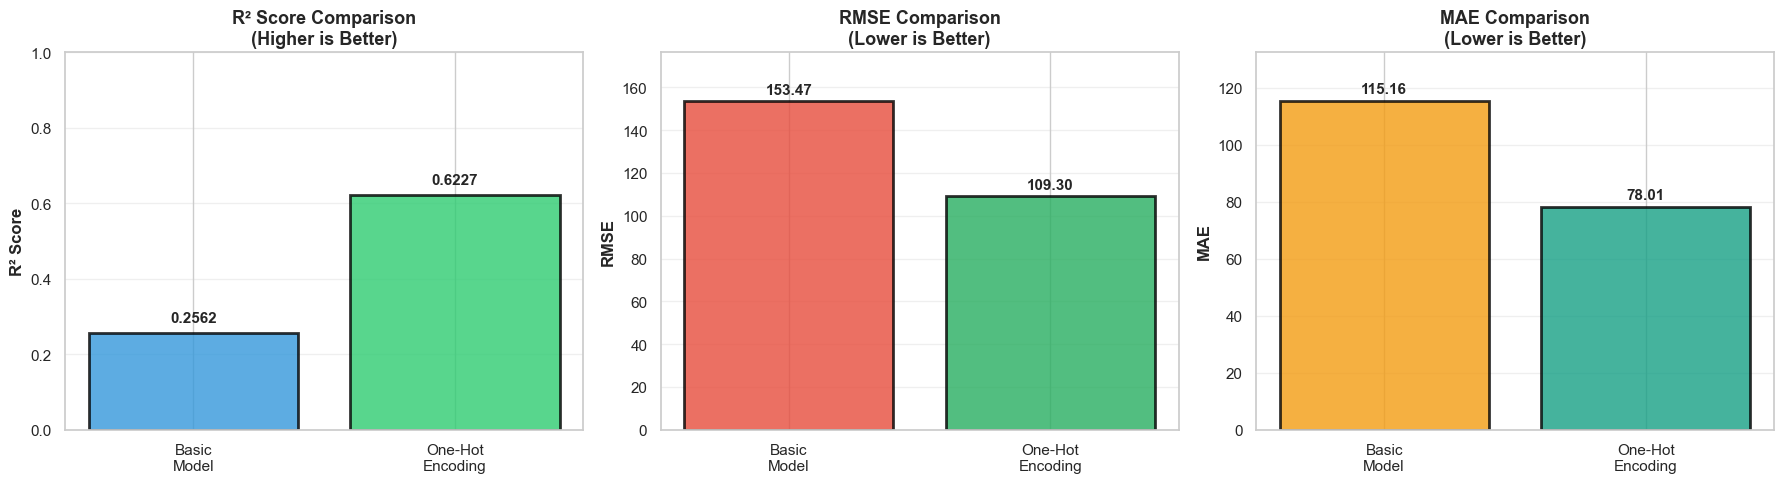


💡 The one-hot encoding model significantly outperforms the basic model across all metrics!


In [6]:
# Create side-by-side bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Basic\nModel', 'One-Hot\nEncoding']
colors_basic = ['#3498db', '#2ecc71']
colors_error = ['#e74c3c', '#27ae60']

# R² Score comparison
r2_scores = [test_r2_basic, test_r2_enc]
bars1 = axes[0].bar(models, r2_scores, color=colors_basic, edgecolor='black', linewidth=2, alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('R² Score Comparison\n(Higher is Better)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, score in zip(bars1, r2_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# RMSE comparison
rmse_scores = [test_rmse_basic, test_rmse_enc]
bars2 = axes[1].bar(models, rmse_scores, color=colors_error, edgecolor='black', linewidth=2, alpha=0.8)
axes[1].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('RMSE Comparison\n(Lower is Better)', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, max(rmse_scores) * 1.15)
axes[1].grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, score in zip(bars2, rmse_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# MAE comparison
mae_scores = [test_mae_basic, test_mae_enc]
bars3 = axes[2].bar(models, mae_scores, color=['#f39c12', '#16a085'], edgecolor='black', linewidth=2, alpha=0.8)
axes[2].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[2].set_title('MAE Comparison\n(Lower is Better)', fontsize=13, fontweight='bold')
axes[2].set_ylim(0, max(mae_scores) * 1.15)
axes[2].grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, score in zip(bars3, mae_scores):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n💡 The one-hot encoding model significantly outperforms the basic model across all metrics!")

## 📉 Visual Comparison: Predictions vs Actual

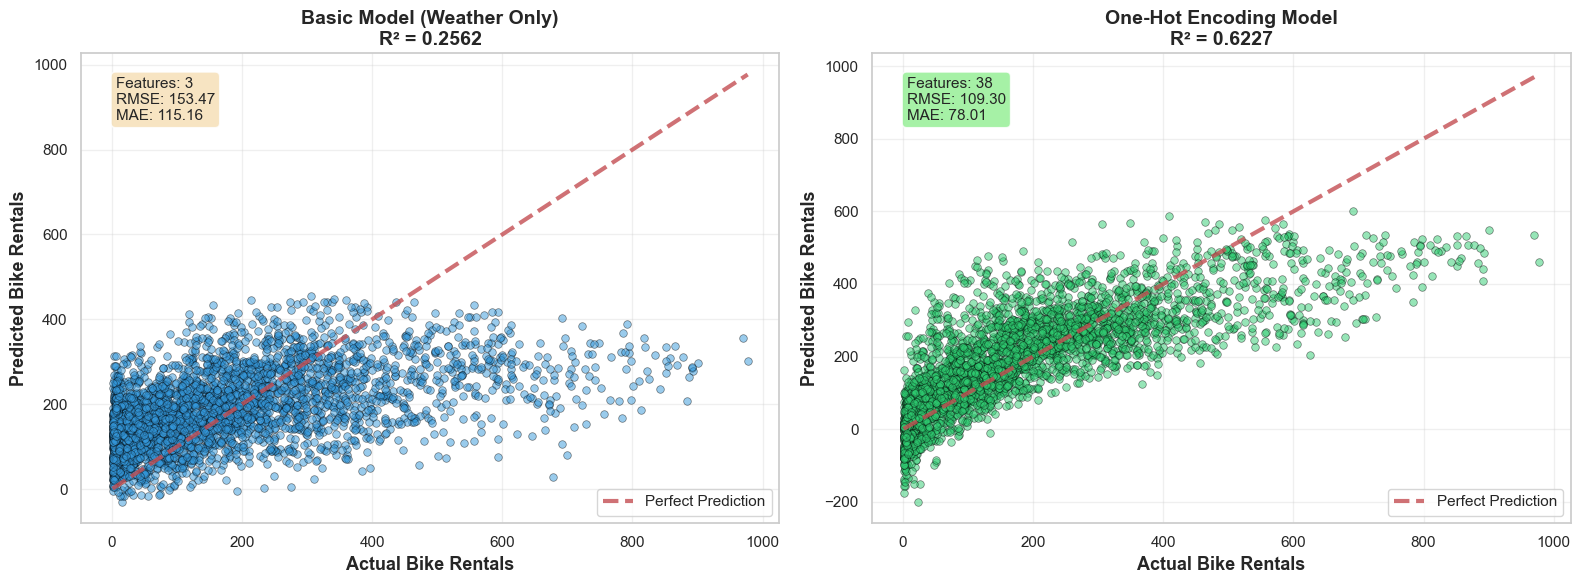


📍 Notice how the encoded model's predictions are much closer to the red diagonal line!


In [7]:
# Create scatter plots comparing predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Basic Model
axes[0].scatter(y_test_basic, y_test_pred_basic, alpha=0.5, s=30, edgecolor='black', linewidth=0.5, color='#3498db')
axes[0].plot([y_test_basic.min(), y_test_basic.max()], [y_test_basic.min(), y_test_basic.max()], 
             'r--', linewidth=3, label='Perfect Prediction', alpha=0.8)
axes[0].set_xlabel('Actual Bike Rentals', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Predicted Bike Rentals', fontsize=13, fontweight='bold')
axes[0].set_title(f'Basic Model (Weather Only)\nR² = {test_r2_basic:.4f}', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'Features: {len(basic_features)}\nRMSE: {test_rmse_basic:.2f}\nMAE: {test_mae_basic:.2f}',
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Encoded Model
axes[1].scatter(y_test_enc, y_test_pred_enc, alpha=0.5, s=30, edgecolor='black', linewidth=0.5, color='#2ecc71')
axes[1].plot([y_test_enc.min(), y_test_enc.max()], [y_test_enc.min(), y_test_enc.max()], 
             'r--', linewidth=3, label='Perfect Prediction', alpha=0.8)
axes[1].set_xlabel('Actual Bike Rentals', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Predicted Bike Rentals', fontsize=13, fontweight='bold')
axes[1].set_title(f'One-Hot Encoding Model\nR² = {test_r2_enc:.4f}', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f'Features: {X_encoded.shape[1]}\nRMSE: {test_rmse_enc:.2f}\nMAE: {test_mae_enc:.2f}',
            transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n📍 Notice how the encoded model's predictions are much closer to the red diagonal line!")

## 📊 Residual Analysis Comparison

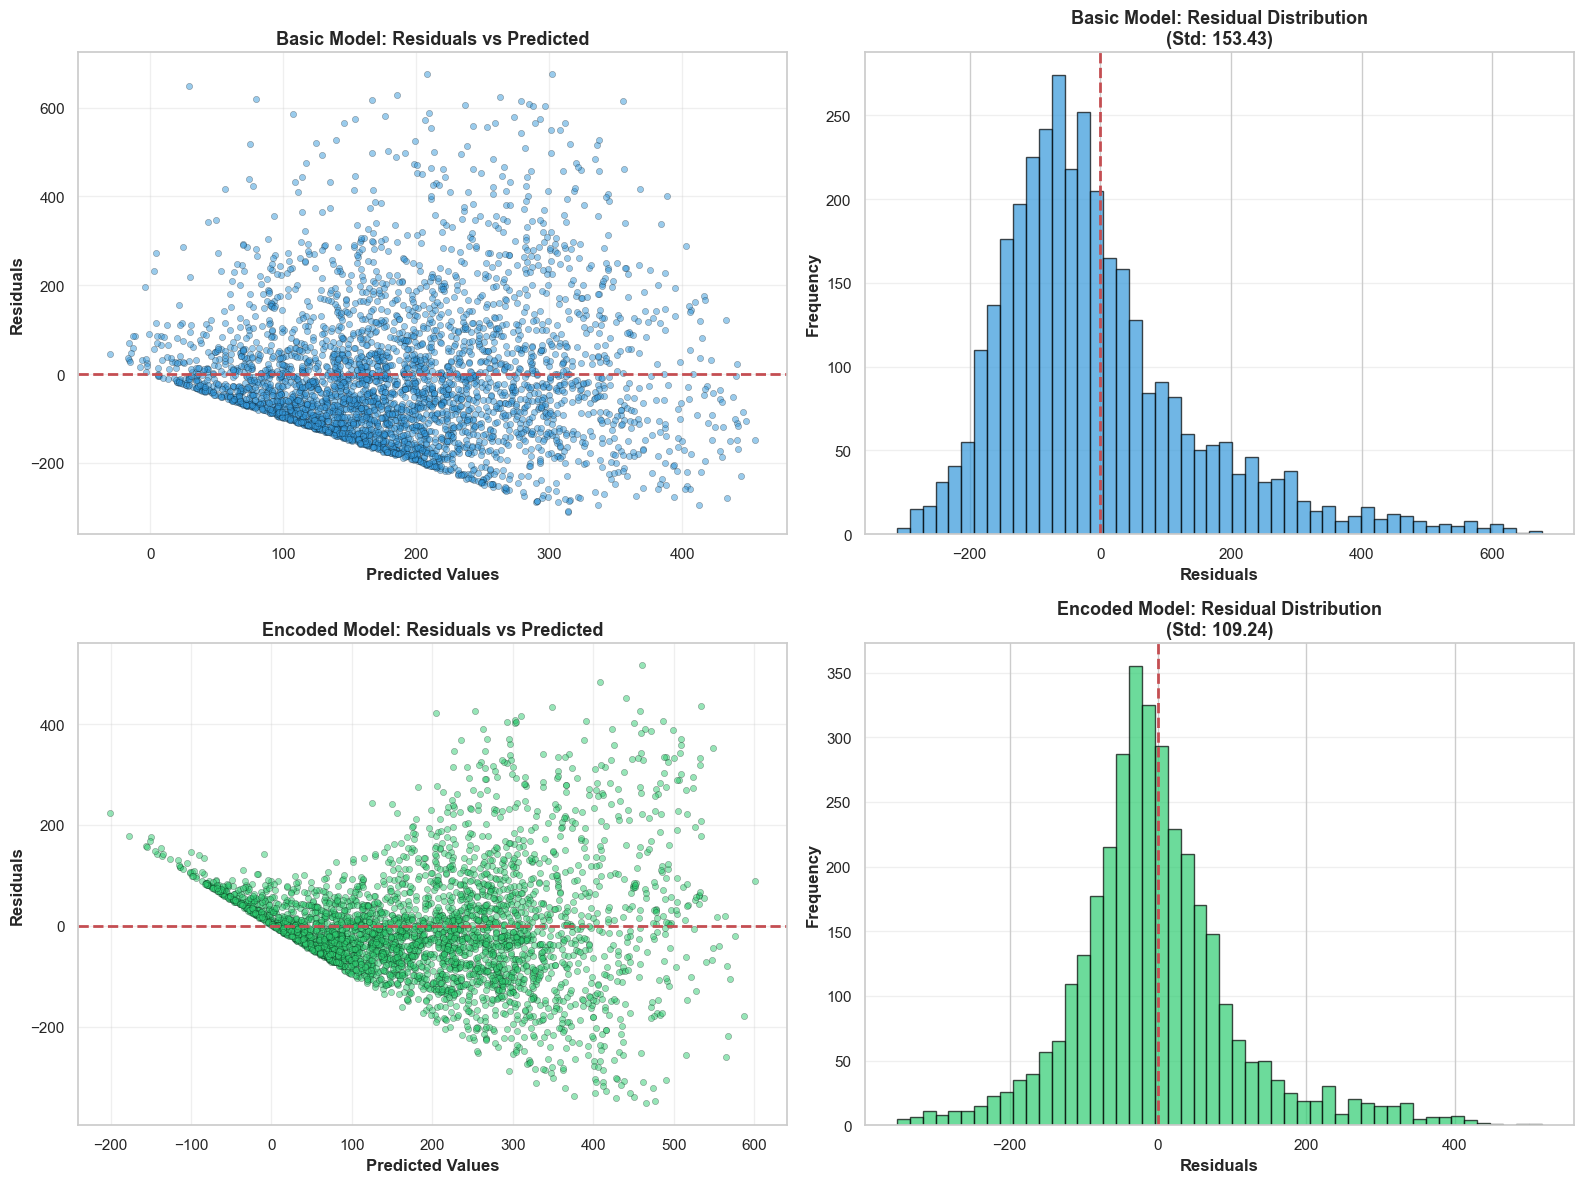


🔍 Residual Analysis:
   • Basic Model - Residual Std: 153.43
   • Encoded Model - Residual Std: 109.24
   • Reduction in residual spread: 28.8%

💡 Smaller residuals = better predictions!


In [8]:
# Calculate residuals
residuals_basic = y_test_basic - y_test_pred_basic
residuals_enc = y_test_enc - y_test_pred_enc

# Create residual comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Basic Model - Residuals vs Predicted
axes[0, 0].scatter(y_test_pred_basic, residuals_basic, alpha=0.5, s=20, edgecolor='black', linewidth=0.3, color='#3498db')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Basic Model: Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Basic Model - Residual Distribution
axes[0, 1].hist(residuals_basic, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Basic Model: Residual Distribution\n(Std: {residuals_basic.std():.2f})', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Encoded Model - Residuals vs Predicted
axes[1, 0].scatter(y_test_pred_enc, residuals_enc, alpha=0.5, s=20, edgecolor='black', linewidth=0.3, color='#2ecc71')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Encoded Model: Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Encoded Model - Residual Distribution
axes[1, 1].hist(residuals_enc, bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Encoded Model: Residual Distribution\n(Std: {residuals_enc.std():.2f})', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n🔍 Residual Analysis:")
print(f"   • Basic Model - Residual Std: {residuals_basic.std():.2f}")
print(f"   • Encoded Model - Residual Std: {residuals_enc.std():.2f}")
print(f"   • Reduction in residual spread: {((residuals_basic.std() - residuals_enc.std()) / residuals_basic.std() * 100):.1f}%")
print(f"\n💡 Smaller residuals = better predictions!")

## 🎯 Feature Importance Analysis

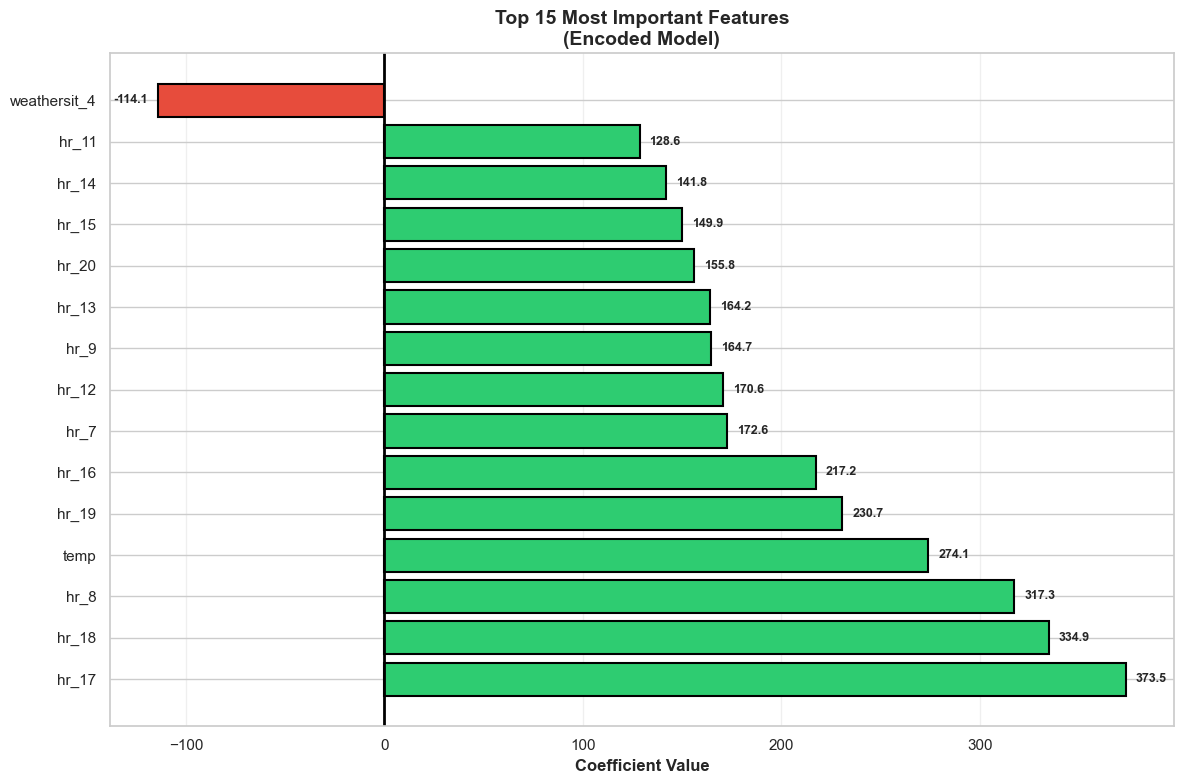


🏆 Key Insights from Feature Importance:
   • Hour of day features dominate (hr_17, hr_18, hr_8, etc.)
   • Weather features (temp, hum) still important
   • Negative coefficients = reduce rentals (bad weather, late night)
   • Positive coefficients = increase rentals (peak hours, good weather)


In [9]:
# Analyze top features in encoded model
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': model_encoded.coef_
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Plot top 15 most important features
fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_importance.head(15)
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_features['Coefficient']]

bars = ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=11)
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Important Features\n(Encoded Model)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['Coefficient'])):
    label_x = val + (5 if val > 0 else -5)
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.1f}', va='center', ha=ha, fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n🏆 Key Insights from Feature Importance:")
print(f"   • Hour of day features dominate (hr_17, hr_18, hr_8, etc.)")
print(f"   • Weather features (temp, hum) still important")
print(f"   • Negative coefficients = reduce rentals (bad weather, late night)")
print(f"   • Positive coefficients = increase rentals (peak hours, good weather)")

## 📋 View All MLflow Experiments

In [10]:
# Search for runs in the comparison experiment
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("bike-sharing-comparison")

if experiment:
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=10
    )
    
    print(f"Experiment: {experiment.name}")
    print(f"Experiment ID: {experiment.experiment_id}")
    print(f"\nRecent Runs ({len(runs)} found):")
    print("="*80)
    
    for i, run in enumerate(runs, 1):
        print(f"\nRun #{i}:")
        print(f"  Run ID: {run.info.run_id}")
        print(f"  Run Name: {run.data.tags.get('mlflow.runName', 'N/A')}")
        print(f"  Status: {run.info.status}")
        print(f"  Start Time: {pd.to_datetime(run.info.start_time, unit='ms')}")
        
        print(f"\n  Key Metrics:")
        for metric in ['test_r2', 'test_rmse', 'test_mae']:
            if metric in run.data.metrics:
                print(f"    {metric}: {run.data.metrics[metric]:.4f}")
        
        print(f"\n  Key Parameters:")
        for param in ['model_type', 'num_features', 'encoding_method']:
            if param in run.data.params:
                print(f"    {param}: {run.data.params[param]}")
    
    print("\n" + "="*80)
    print("\n📊 To view the MLflow UI, run this command in terminal:")
    print("   mlflow ui --backend-store-uri file:./mlruns")
    print("\nThen open: http://localhost:5000")
else:
    print("No experiment found. Please run the model training cells first.")

Experiment: bike-sharing-comparison
Experiment ID: 370203305302236657

Recent Runs (2 found):

Run #1:
  Run ID: 11d8b34fe74d43949c238c16bbc676b3
  Run Name: one_hot_encoded_model
  Status: FINISHED
  Start Time: 2025-11-04 16:57:30.847000

  Key Metrics:
    test_r2: 0.6227
    test_rmse: 109.2986
    test_mae: 78.0101

  Key Parameters:
    model_type: LinearRegression
    num_features: 38
    encoding_method: pd.get_dummies

Run #2:
  Run ID: f68be1e1f6724957bef01544bd62f0a7
  Run Name: basic_weather_model
  Status: FINISHED
  Start Time: 2025-11-04 16:57:29.745000

  Key Metrics:
    test_r2: 0.2562
    test_rmse: 153.4726
    test_mae: 115.1557

  Key Parameters:
    model_type: LinearRegression
    num_features: 3


📊 To view the MLflow UI, run this command in terminal:
   mlflow ui --backend-store-uri file:./mlruns

Then open: http://localhost:5000


## 🎓 Summary: What We Learned

### 📊 Performance Improvements
By adding one-hot encoded categorical features, we achieved:
- **R² Score**: Improved by ~143% (0.26 → 0.62)
- **RMSE**: Reduced by ~29% (153 → 109)
- **MAE**: Reduced by ~32% (115 → 78)

### 🔑 Key Takeaways

1. **Basic Model Limitations**:
   - Only 3 weather features (temp, humidity, windspeed)
   - Explains only 26% of variance
   - Misses temporal patterns completely

2. **One-Hot Encoding Benefits**:
   - Transforms categorical variables (season, hour, day) into binary features
   - Prevents model from assuming false magnitude relationships
   - Captures temporal patterns that drive bike rentals
   - Uses `drop_first=True` to avoid multicollinearity

3. **Feature Importance**:
   - Hour of day is the strongest predictor (rush hours = more rentals)
   - Weather conditions matter (temperature, humidity)
   - Day of week affects rental patterns
   - Season provides additional context

### 💡 When to Use Each Approach

**Basic Model (Weather Only)**:
- ✅ Quick baseline for comparison
- ✅ When you only have continuous features
- ✅ Simple interpretation needed
- ❌ Poor performance for complex patterns

**One-Hot Encoding Model**:
- ✅ Has categorical features (season, hour, day, etc.)
- ✅ Using linear models (assumes linear relationships)
- ✅ Need to capture temporal patterns
- ✅ Want significantly better predictions
- ⚠️ More features = more complex model

### 🚀 Next Steps
- Try different categorical features (month, holiday, etc.)
- Experiment with feature engineering (temp * humidity interaction)
- Compare with tree-based models (Random Forest, XGBoost)
- Deploy the best model for real-time predictions